In [ ]:
import numpy as np
import torch
import time
import torchvision
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms as tt
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
os.getcwd()

'/content'

In [ ]:
# from data_preprocessing import load_npz_files, Dataset_Preprocessing, data_check_plot_tensor_figures
from data_preprocessing import load_npz_files
# from GAN_training import DC_GAN_training

### Checking GPU info

In [ ]:
print('torch.cuda.is_available(): ' + str(torch.cuda.is_available()))

torch.cuda.is_available(): True


In [ ]:
!nvidia-smi

Sat Mar 11 18:29:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |   1949MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# clean up GPU Ram -> none of them worked

# import gc
# gc.collect()
# !kill 14998
# with torch.no_grad():
#     torch.cuda.empty_cache()

In [ ]:
current_dir = os.getcwd()
derma = load_npz_files(current_dir + '/dermamnist.npz')
# derma.files

# I hereby to concatenate all 3 datasets
# because we do not need val/test in GAN, as its a unsupervised algorithm
train = derma['train_images'] # numpy array
val = derma['val_images']
test = derma['test_images']
# train_label = derma['train_labels']
concatenate_img = np.concatenate((train, val, test))
# concatenate_img = concatenate_img.reshape(10015, 3, 28, 28)
# thus we concatenate all the images

img23 shape (28, 28, 3)


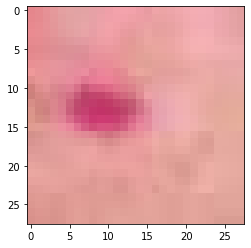

In [ ]:
img23 = concatenate_img[23]
print('img23 shape', img23.shape)
plt.imshow(img23)


In [ ]:
transform = tt.Compose([
    tt.ToTensor(), # one thing to mention: ToTensor() automatically transform images to 3,28,28 from 28,28,3
    # tt.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    tt.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])   
img23_tensor = transform(img23)
print('tensor img23 shape: ', img23_tensor.shape)
print(torch.max(img23_tensor))
print(torch.min(img23_tensor))
print(torch.mean(img23_tensor,[1,2]))

tensor img23 shape:  torch.Size([3, 28, 28])
tensor(0.9294)
tensor(-0.6000)
tensor([0.7845, 0.2040, 0.2101])


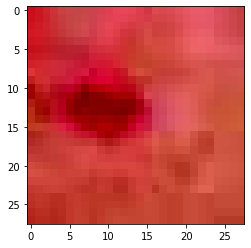

In [ ]:
plt.imshow(img23_tensor.permute(1,2,0))

In [ ]:
# Generator Settings
# Device -> will use in google colab
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print('Device:', DEVICE)

Device: cuda


In [ ]:
# use fixed noise to generate
# if on GPU
# fixed_noise = torch.randn(128, 100, device=DEVICE) # format NCHW
fixed_noise = torch.randn(128, 100, 1, 1, device=DEVICE)
# noises are from a (128, 100, 1, 1) high-dimensional(latent dimension: 100-dimension) normal distribution with mean 0 and variance 1
# I randomly decide the dimension numbers -> but should keep consistency later
print('fixed noise shape: ', fixed_noise.shape)

fixed noise shape:  torch.Size([128, 100, 1, 1])


## DCGAN records, without wasserstain distance and gradient penalty
* 1st model 02/06, with discriminator AlexNet, generator 5 conv layers
    * discriminator: 2 conv layers + 3 linear layers, tanh()
    * generator: 5 conv layers, tanh()
    * failed, architecture saved in models.ipynb
    128 100, 1,1 -> 128 100


* 2nd model 02/10, with discriminator 4 conv layers, generator 5 conv layers
    * disc: 4 conv layers, batchNorm, leakyRelu, dropout, flatten, no activation
    * generator: 5 conv layers, batchNorm, relu, tanh()
    * soft labeling
    * failede, saved in models.ipynb
    * **02/24 edited, the reason why it not succeed is that too many chanels in generator**

* 3rd model 02/12, with discriminator 5 conv layers, generator 5 conv layers, which is exact same architecture in the dcgan tutorial
    * images (0,1)
    * disc: 5 conv layers, batchNorm, leakyRelu, dropout, flatten
    * generator: 5 conv layers, batchNorm, relu, sigmoid()
    * soft labeling
    * failed, saved in models.ipynb
    * **02/24 edited, the reason why it not succeed is that too many chanels in generator**


* 4th model 02/17, with discriminator 2 conv layers + 1 linear, generator 3 conv layers

    * disc: 2 conv layers + 1 linear, batchNorm, leakyRelu, flatten
    * generator: 3 conv layers, batchNorm, relu, tanh
    * soft labeling
    * failed, saved in models.ipynb, **02/24 edited same reason as above**

* 5th model 02/19, with discriminator 3 conv layers + 1 linear, generator 3 conv layers

    * gen: reshape the noise from 100 to 16 * 4 * 4 first, **turns out that this is a key step for traning**
    * **reduce the channels in generator**
    * disc: 3 conv layers + 1 linear, batchNorm, leakyRelu, flatten
    * generator: reshape + 3 conv layers, batchNorm, leakyRelu, tanh
    * soft labeling
    * it finally starts to learn something, but mode collapse happened

* 6th model 02/20, extend the layers for 5th model

    * gen: reshape the noise from 100 to 16 * 4 * 4 first, **exactly as what I did in 5th model**
    * disc: 5 conv layers, batchNorm, leakyRelu, flatten, tanh
    * generator: rehape + 5 conv layers, batchNorm, relu, tanh
    * mode collapse again


In [ ]:
# 02/24

# it finally starts to learn something, but mode collapse happened

class DC_GAN(torch.nn.Module):
        
    # latent dimension is for noise sampling
    def __init__(self, latent_dimension, image_height, image_width, color_channels): 
        super().__init__()
        self.latent_dimension = latent_dimension
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        # 3 conv layers
        self.generator = nn.Sequential(
            torch.nn.Linear(self.latent_dimension,256),
            torch.nn.Unflatten(1,(16,4,4)),
            torch.nn.ConvTranspose2d(in_channels=16,
                                     out_channels=4*self.image_height,
                                     kernel_size=(4,4),
                                     stride=(1,1),
                                     padding=0
            ),
            torch.nn.BatchNorm2d(4*self.image_height),
            # Relu or LeakyReLU remains for test
            torch.nn.LeakyReLU(),
            
            torch.nn.ConvTranspose2d(in_channels=4*self.image_height,
                                     out_channels=2*self.image_height,
                                     kernel_size=(2,2),
                                     stride=(2,2),
                                     padding=0
            ),
            torch.nn.BatchNorm2d(2*self.image_height),
            torch.nn.LeakyReLU(),

            torch.nn.ConvTranspose2d(in_channels=2*self.image_height,
                                     out_channels=self.color_channels,
                                     kernel_size=(2,2),
                                     stride=(2,2),
                                     padding=0
            ),
            torch.nn.Tanh()
            # torch.nn.Sigmoid() # [N, 3, 28, 28]
        )

        # Lets use fully convolutional network
        # 5convs
        self.discriminator = nn.Sequential(
            torch.nn.Conv2d(in_channels=3,
                            out_channels=32,
                            kernel_size=(3,3),
                            stride=(2,2),
                            padding=1
                           ),
            # torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(0.2, inplace=True), # 
            # dropout are for test
            # torch.nn.Dropout2d(p=0.5),
            torch.nn.Conv2d(in_channels=32,
                            out_channels=64,
                            kernel_size=(3,3),
                            stride=(2,2),
                            padding=1
                           ),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True), #
            # torch.nn.Dropout2d(p=0.5),
            torch.nn.Conv2d(in_channels=64,
                            out_channels=128,
                            kernel_size=(3,3),
                            stride=(2,2),
                            padding=1
                            ),
            torch.nn.LeakyReLU(0.2, inplace=True),                
            torch.nn.AvgPool2d(4), 
            torch.nn.Flatten(),                                                
            torch.nn.Linear(128,1),
            torch.nn.Tanh(),           
        )
        
    def generator_forward(self, z):
        img = self.generator(z)
        return img
        
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits
        

In [ ]:
# # 03/11

# # no reshape in generator -> works really good though 
# # 3 convolutional layers

# class DC_GAN(torch.nn.Module):
        
#     # latent dimension is for noise sampling
#     def __init__(self, latent_dimension, image_height, image_width, color_channels): 
#         super().__init__()
#         self.latent_dimension = latent_dimension
#         self.image_height = image_height
#         self.image_width = image_width
#         self.color_channels = color_channels
        
#         # 3 conv layers
#         self.generator = nn.Sequential(
#             # torch.nn.Linear(self.latent_dimension,256),
#             # torch.nn.Unflatten(1,(16,4,4)),
#             torch.nn.ConvTranspose2d(in_channels=self.latent_dimension,
#                                      out_channels=4*self.image_height,
#                                      kernel_size=(4,4),
#                                      stride=(3,3),
#                                      padding=0
#             ),
#             torch.nn.BatchNorm2d(4*self.image_height),
#             # Relu or LeakyReLU remains for test
#             torch.nn.LeakyReLU(),
            
#             torch.nn.ConvTranspose2d(in_channels=4*self.image_height,
#                                      out_channels=2*self.image_height,
#                                      kernel_size=(4,4),
#                                      stride=(3,3),
#                                      padding=0
#             ),
#             torch.nn.BatchNorm2d(2*self.image_height),
#             torch.nn.LeakyReLU(),

#             torch.nn.ConvTranspose2d(in_channels=2*self.image_height,
#                                      out_channels=self.color_channels,
#                                      kernel_size=(4,4),
#                                      stride=(2,2),
#                                      padding=0
#             ),
#             # torch.nn.Tanh()
#             torch.nn.Sigmoid() # [N, 3, 28, 28]
#         )

#         # Lets use fully convolutional network
#         # 3convs
#         self.discriminator = nn.Sequential(
#             torch.nn.Conv2d(in_channels=3,
#                             out_channels=32,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                            ),
#             # torch.nn.BatchNorm2d(16),
#             torch.nn.LeakyReLU(0.2, inplace=True), # 
#             # dropout are for test
#             # torch.nn.Dropout2d(p=0.5),
#             torch.nn.Conv2d(in_channels=32,
#                             out_channels=64,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                            ),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.LeakyReLU(0.2, inplace=True), #
#             # torch.nn.Dropout2d(p=0.5),
#             torch.nn.Conv2d(in_channels=64,
#                             out_channels=128,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                             ),
#             torch.nn.LeakyReLU(0.2, inplace=True),                
#             torch.nn.AvgPool2d(4), 
#             torch.nn.Flatten(),                                                
#             torch.nn.Linear(128,1),
#             torch.nn.Tanh(),           
#         )
        
#     def generator_forward(self, z):
#         img = self.generator(z)
#         return img
        
#     def discriminator_forward(self, img):
#         logits = self.discriminator(img)
#         return logits
        

In [ ]:
# # # below here just to make sure the shape dimensions
# # # generator
# seq1 = nn.Sequential(
# #             torch.nn.Linear(100,256),
# #             torch.nn.Unflatten(1,(16,4,4)),
#             torch.nn.ConvTranspose2d(in_channels=100,
#                                      out_channels=4*28,
#                                      kernel_size=4,
#                                      stride=3,
#                                      padding=0
#             ),
            
#             # Relu or LeakyRelu remains for test
#             torch.nn.ReLU(),
#             torch.nn.ConvTranspose2d(in_channels=4*28,
#                                      out_channels=8*28,
#                                      kernel_size=4,
#                                      stride=1,
#                                      padding=1
#                                      ),
            
#             torch.nn.ConvTranspose2d(in_channels=8*28,
#                                      out_channels=4*28,
#                                      kernel_size=4,
#                                      stride=1,
#                                      padding=1
#                                     ),
            
#             torch.nn.ConvTranspose2d(in_channels=4*28,
#                                      out_channels=2*28,
#                                      kernel_size=4,
#                                      stride=3,
#                                      padding=0
#                                     ),
            
#             torch.nn.ConvTranspose2d(in_channels=2*28,
#                                      out_channels=3,
#                                      kernel_size=4,
#                                      stride=2,
#                                      padding=0
#                                     ),
#             torch.nn.Tanh(),     
# #             # 3*28*28

# )

In [ ]:
# figure out the shape from generator
# make it back to 128,3,28,28
fixed_noise_ = torch.randn(128, 100, 1, 1)
# fixed_noise_ = torch.randn(128, 100)
fn_1 = seq1(fixed_noise_)
print(fn_1.shape)

torch.Size([128, 3, 28, 28])


In [ ]:
# # below here just to make sure the shape dimensions

# # discriminator
# seq2 = nn.Sequential(
#                 torch.nn.Conv2d(in_channels=3,
#                             out_channels=32,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                            ),
                     
#                 torch.nn.Conv2d(in_channels=32,
#                                 out_channels=64,
#                                 kernel_size=(3,3),
#                                 stride=(2,2),
#                                 padding=1
#                                ),
                     
#                 torch.nn.Conv2d(in_channels=64,
#                                 out_channels=128,
#                                 kernel_size=(3,3),
#                                 stride=(2,2),
#                                 padding=1
#                                 ),  
                     
#                 torch.nn.Conv2d(in_channels=128,
#                                 out_channels=32,
#                                 kernel_size=(3,3),
#                                 stride=(2,2),
#                                 padding=1
#                                ),     
#                 torch.nn.Conv2d(in_channels=64,
#                                 out_channels=128,
#                                 kernel_size=(3,3),
#                                 stride=(2,2),
#                                 padding=1
#                                ),
#                 torch.nn.LeakyReLU(0.2, inplace=True),                
#                 torch.nn.AvgPool2d(4), 
#                 torch.nn.Flatten(),                                                
#                 torch.nn.Linear(128,1),
# #                 torch.nn.Flatten(),
# #                 # torch.nn.Tanh() # (-1, 1)
# )

In [ ]:
# figure out the shape from generator
# make it back to N,16,28,28 -> N, 50176
fn_2 = seq2(fn_1)
print(fn_2.shape)

torch.Size([128, 1])


In [ ]:
# # 02/26
# # its okay, but mode collapse happens
# # reshape when it goes into generator

# class DC_GAN_5(torch.nn.Module):
        
#     # latent dimension is for noise sampling
#     def __init__(self, latent_dimension, image_height, image_width, color_channels): 
#         super().__init__()
#         self.latent_dimension = latent_dimension
#         self.image_height = image_height
#         self.image_width = image_width
#         self.color_channels = color_channels
        
#         # 5 conv layers
#         self.generator = nn.Sequential(
#             torch.nn.Linear(self.latent_dimension,256),
#             torch.nn.Unflatten(1,(16,4,4)),
#             torch.nn.ConvTranspose2d(in_channels=16,
#                                      out_channels=4*self.image_height,
#                                      kernel_size=(4,4),
#                                      stride=(1,1),
#                                      padding=1
#             ),
#             torch.nn.BatchNorm2d(4*self.image_height),
#             # Relu or LeakyReLU remains for test
#             torch.nn.LeakyReLU(),

#             torch.nn.ConvTranspose2d(in_channels=4*self.image_height,
#                                      out_channels=8*self.image_height,
#                                      kernel_size=(4,4),
#                                      stride=(1,1),
#                                      padding=1
#                                     ),
#             torch.nn.BatchNorm2d(8*self.image_height),
#             torch.nn.LeakyReLU(),
            
#             torch.nn.ConvTranspose2d(in_channels=8*self.image_height,
#                                      out_channels=4*self.image_height,
#                                      kernel_size=(4,4),
#                                      stride=(1,1),
#                                      padding=1
#                                     ),  
#             torch.nn.BatchNorm2d(4*self.image_height),
#             torch.nn.LeakyReLU(),

#             torch.nn.ConvTranspose2d(in_channels=4*self.image_height,
#                                      out_channels=2*self.image_height,
#                                      kernel_size=(4,4),
#                                      stride=(2,2),
#                                      padding=1
#             ),
#             torch.nn.BatchNorm2d(2*self.image_height),
#             torch.nn.LeakyReLU(),

#             torch.nn.ConvTranspose2d(in_channels=2*self.image_height,
#                                      out_channels=self.color_channels,
#                                      kernel_size=(4,4),
#                                      stride=(2,2),
#                                      padding=1
#             ),
#             # torch.nn.Tanh()
#             torch.nn.Sigmoid() # [N, 3, 28, 28]
#         )

#         # Lets use fully convolutional network
#         # 5convs
#         self.discriminator = nn.Sequential(
#             torch.nn.Conv2d(in_channels=3,
#                             out_channels=32,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                            ),
#             # torch.nn.BatchNorm2d(16),
#             torch.nn.LeakyReLU(0.2, inplace=True), 
#             # dropout are for test
#             # torch.nn.Dropout2d(p=0.5),
#             torch.nn.Conv2d(in_channels=32,
#                             out_channels=64,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                            ),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.LeakyReLU(0.2, inplace=True), 
#             # torch.nn.Dropout2d(p=0.5),
            
#             torch.nn.Conv2d(in_channels=64,
#                             out_channels=128,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                             ),
#             torch.nn.BatchNorm2d(128),
#             torch.nn.LeakyReLU(0.2, inplace=True),

#             torch.nn.Conv2d(in_channels=128,
#                             out_channels=32,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                            ),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.LeakyReLU(0.2, inplace=True), 
            
#             torch.nn.Conv2d(in_channels=32,
#                             out_channels=1,
#                             kernel_size=(4,4),
#                             stride=(1,1),
#                             padding=1
#                            ),
#             torch.nn.Flatten(),
#             # torch.nn.Tanh(),
#             torch.nn.Sigmoid(),
      
#         )
        
#     def generator_forward(self, z):
#         img = self.generator(z)
#         return img
        
#     def discriminator_forward(self, img):
#         logits = self.discriminator(img)
#         return logits
        

In [ ]:
# # 03/11
# # not good
# # no reshape when it goes into generator

# class DC_GAN_5(torch.nn.Module):
        
#     # latent dimension is for noise sampling
#     def __init__(self, latent_dimension, image_height, image_width, color_channels): 
#         super().__init__()
#         self.latent_dimension = latent_dimension
#         self.image_height = image_height
#         self.image_width = image_width
#         self.color_channels = color_channels
        
#         # 5 conv layers
#         self.generator = nn.Sequential(
#             torch.nn.ConvTranspose2d(in_channels=self.latent_dimension,
#                                      out_channels=4*self.image_height,
#                                      kernel_size=(4,4),
#                                      stride=(2,2),
#                                      padding=1
#             ),
#             torch.nn.BatchNorm2d(4*self.image_height),
#             # Relu or LeakyReLU remains for test
#             torch.nn.LeakyReLU(),

#             torch.nn.ConvTranspose2d(in_channels=4*self.image_height,
#                                      out_channels=8*self.image_height,
#                                      kernel_size=(4,4),
#                                      stride=(2,2),
#                                      padding=1
#                                     ),
#             torch.nn.BatchNorm2d(8*self.image_height),
#             torch.nn.LeakyReLU(),
            
#             torch.nn.ConvTranspose2d(in_channels=8*self.image_height,
#                                      out_channels=4*self.image_height,
#                                      kernel_size=(4,4),
#                                      stride=(2,2),
#                                      padding=1
#                                     ),  
#             torch.nn.BatchNorm2d(4*self.image_height),
#             torch.nn.LeakyReLU(),

#             torch.nn.ConvTranspose2d(in_channels=4*self.image_height,
#                                      out_channels=2*self.image_height,
#                                      kernel_size=(4,4),
#                                      stride=(2,2),
#                                      padding=1
#             ),
#             torch.nn.BatchNorm2d(2*self.image_height),
#             torch.nn.LeakyReLU(),

#             torch.nn.ConvTranspose2d(in_channels=2*self.image_height,
#                                      out_channels=self.color_channels,
#                                      kernel_size=(2,2),
#                                      stride=(2,2),
#                                      padding=2
#             ),
#             # torch.nn.Tanh()
#             torch.nn.Sigmoid() # [N, 3, 28, 28]
#         )

#         # Lets use fully convolutional network
#         # 5convs
#         self.discriminator = nn.Sequential(
#             torch.nn.Conv2d(in_channels=3,
#                             out_channels=32,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                            ),
#             # torch.nn.BatchNorm2d(16),
#             torch.nn.LeakyReLU(0.2, inplace=True), 
#             # dropout are for test
#             # torch.nn.Dropout2d(p=0.5),
#             torch.nn.Conv2d(in_channels=32,
#                             out_channels=64,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                            ),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.LeakyReLU(0.2, inplace=True), 
#             # torch.nn.Dropout2d(p=0.5),
            
#             torch.nn.Conv2d(in_channels=64,
#                             out_channels=128,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                             ),
#             torch.nn.BatchNorm2d(128),
#             torch.nn.LeakyReLU(0.2, inplace=True),

#             torch.nn.Conv2d(in_channels=128,
#                             out_channels=64,
#                             kernel_size=(3,3),
#                             stride=(2,2),
#                             padding=1
#                            ),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.LeakyReLU(0.2, inplace=True), 
            
#             torch.nn.Conv2d(in_channels=64,
#                             out_channels=1,
#                             kernel_size=(4,4),
#                             stride=(1,1),
#                             padding=1
#                            ),
#             torch.nn.Flatten(),
#             torch.nn.Sigmoid()
#             # torch.nn.Tanh(),
      
#         )
        
#     def generator_forward(self, z):
#         img = self.generator(z)
#         return img
        
#     def discriminator_forward(self, img):
#         logits = self.discriminator(img)
#         return logits
        

In [ ]:
# # do not know how to use
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)

In [ ]:
def data_check_plot_tensor_figures(figures, nrows = 1, ncols=1):
    """
    Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for index,title in enumerate(figures):
        # axeslist.ravel()[index].imshow(figures[title].detach().numpy().transpose(1,2,0))
        # if model is up on GPU
        axeslist.ravel()[index].imshow(figures[title].cpu().detach().numpy().transpose(1,2,0))
        axeslist.ravel()[index].set_title(title)
        axeslist.ravel()[index].set_axis_off()
    plt.tight_layout() # optional

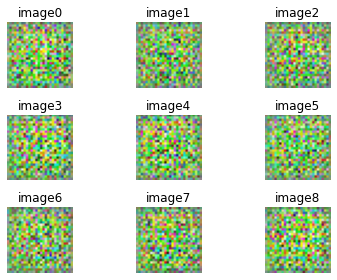

In [ ]:
# look if the model can generate noises
# dcgan = DC_GAN(100,28,28,3)
dcgan = DC_GAN_5(100,28,28,3)
dcgan.to(DEVICE)

# fixed_noise = torch.randn(128, 100, 1, 1, device=DEVICE)
fixed_noise = torch.randn(128, 100, device=DEVICE)

# generate fake images
fake_images = dcgan.generator_forward(fixed_noise)
# lets check 9 images of these fake images
number_of_img = 9
# data dictionary for plotting function
nine_fake_images_ = {'image'+str(i): fake_images[i] for i in range(number_of_img)}
# plot using data_check_plot_figures
data_check_plot_tensor_figures(nine_fake_images_, nrows = 3, ncols=3)

In [ ]:
# make sure one image shape is 3,28,28
fake_images[0].shape

torch.Size([3, 28, 28])

In [ ]:
# test to see if discriminator ever works
fn_1 = fn_1.to(DEVICE)
pred = dcgan.discriminator_forward(fn_1)
pred

In [ ]:
# a train function which will be included in another .py file
def DC_GAN_training(data, model, 
                    num_epochs, 
                    latent_dim, 
                    optim_discr,
                    optim_gen,
                    device,
                    save_model=None):
    # from tutorial and paper, initialize the weights    
    # def weights_init(m):
    #     classname = m.__class__.__name__
    #     if classname.find('Conv') != -1:
    #         nn.init.normal_(m.weight.data, 0.0, 0.02)
    #     elif classname.find('BatchNorm') != -1:
    #         nn.init.normal_(m.weight.data, 1.0, 0.02)
    #         nn.init.constant_(m.bias.data, 0)

    # smmothing the labels, ow discriminator too strong
    # CE for multi-class
    # loss_function = F.cross_entropy 
    # BCE for binary class
    loss_function = F.binary_cross_entropy_with_logits

    log_dict={'train_generator_loss_per_batch': [],
            'train_discriminator_loss_per_batch': [],
            'train_discriminator_real_acc_per_batch': [],
            'train_discriminator_fake_acc_per_batch': [],
            'images_from_noise_per_epoch': []
            }
    # fixed noise is used to generate images when generator is trained
    # fixed_noise = torch.randn(128, latent_dim, 1, 1, device=device)
    fixed_noise = torch.randn(128, latent_dim, device=device)
    start_time = time.time()

    # initialize parameters
    # model.generator.apply(weights_init)
    # model.discriminator.apply(weights_init)

    logging_interval=100
    
    for epoch in range(num_epochs):
        # need to print the image out
        # for step in range(num_epoch):
        model.train()
        for batch_indx, images in enumerate(data): # with batch_index 0-16, and iamges shape NCHW (16,3,28,28)
            batch_size = images.size(0) # how many images in one batch
            
            # real images
            real_images = images.to(device)
            # print('real_images: ', real_images.shape)
            real_labels = torch.ones(batch_size, device=device)
            # print('real_labels: ', real_labels.shape)

            # fake images
            # noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            noise = torch.randn(batch_size, latent_dim, device=device)
            # print('noise shape: ', noise.shape)
            fake_images = model.generator_forward(noise)
            # print('fake_images: ', fake_images.shape)
            fake_labels = torch.zeros(batch_size, device=device)
            # print('fake_labels: ', fake_labels.shape)
            flipped_fake_labels = real_labels # flip the labels for the generator training
            
            #######################################################
            ## same training process as Linear GAN,
            ## we train the discriminator first
            #######################################################
            
            optim_discr.zero_grad()
            
            # calculate loss on real images
            real_img_pred = model.discriminator_forward(real_images).view(-1)
            # print('real_img_pred: ', real_img_pred.shape)

            # label smoothing here to avoid discriminator being too strong
            real_img_loss = loss_function(real_img_pred, real_labels) 
            
            # caculate loss on fake images
            fake_img_pred = model.discriminator_forward(fake_images.detach()).view(-1)
            # print('fake_img_pred: ', fake_img_pred.shape)
            fake_img_loss = loss_function(fake_img_pred, fake_labels) 
            
            # backward propagation
            discriminator_loss = 0.5*(real_img_loss + fake_img_loss)
            # discriminator_loss = 0.7*real_img_loss + 0.3*fake_img_loss
            discriminator_loss.backward(retain_graph=True)
            
            # performs a parameter update based on the current gradient 
            optim_discr.step()
            
            #######################################################
            ## train the generator
            #######################################################
            
            optim_gen.zero_grad()
            
            # calculate loss on generate images
            fake_img_pred = model.discriminator_forward(fake_images).view(-1)
            # flip the label for fake iamges to use gradient descent instead of modifying the loss function
            generator_loss = loss_function(fake_img_pred, flipped_fake_labels) # tricks applied here, fool discriminator
            generator_loss.backward(retain_graph=True)
            
            # performs a parameter update based on the current gradient 
            
            optim_gen.step()
            
            #######################################################
            ## logging
            #######################################################   
            log_dict['train_generator_loss_per_batch'].append(generator_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discriminator_loss.item())
            
            # predicted_labels_real = torch.where(real_img_pred.detach() > 0., 1., 0.)
            # predicted_labels_fake = torch.where(fake_img_pred.detach() > 0., 1., 0.) # because we have flipped lables
            # acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            # acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            # log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            # log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            
            if not batch_indx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                    # % (epoch+1, 100, batch_indx, 
                    % (epoch+1, num_epochs, batch_indx, 
                        len(train), generator_loss.item(), discriminator_loss.item()))

        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
            torchvision.utils.make_grid(fake_images, padding=2, normalize=True))
        
        # plot the images for each epoch, no good then cut it off
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.title(f'Generated images at epoch {epoch}')
        plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][epoch], (1, 2, 0)))
        plt.show()

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))   
    if save_model is not None:
        torch.save(model.state_dict(), save_model) 
    return log_dict

### use customer dataloader

In [ ]:
class Dataset_Preprocessing(Dataset):
    
    'Characterizes a dataset for PyTorch'
    def __init__(self, imgs):
        'Initialization'
        self.imgs = imgs
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.imgs)
    def __getitem__(self, index):
        'Generates one sample of data, will be used by DataLoader'
        # Select sample
        image = self.imgs[index]
        X = self.transform(image)
        return X
        
    transform = tt.Compose([
    tt.ToTensor(), # one thing to mention: ToTensor() automatically transform images to 3,28,28 from 28,28,3
    # tt.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    # tt.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])   


In [ ]:
# perform data standardization before into dataloader
# perform data normalization before into dataloader, no more standardization
concatenate_img_ = Dataset_Preprocessing(imgs=concatenate_img)

In [ ]:
# image size
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 3

BATCH_SIZE = 32
train = DataLoader(dataset=concatenate_img_, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

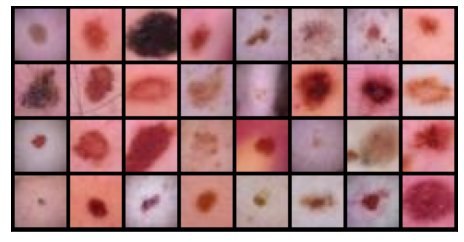

In [ ]:
# make_grid is a very nice function in torchvision
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataset, nmax=64):
    for images in dataset:
        show_images(images, nmax)
        break

show_batch(train)

In [ ]:
# Generator parameters
torch.manual_seed(923)
np.random.seed(923)

LATENT_DIMENSION= 100
NUM_EPOCHS = 100

GENERATOR_LEARNING_RATE = 0.0001
DISCRIMINATOR_LEARNING_RATE = 0.0001

In [ ]:
# set up model
# 3 conv
MODEL = DC_GAN(latent_dimension=LATENT_DIMENSION, 
              image_height=IMAGE_HEIGHT, 
              image_width=IMAGE_WIDTH, 
              color_channels=IMAGE_CHANNELS)

# 5 conv
# MODEL= DC_GAN_5(latent_dimension=LATENT_DIMENSION, 
#               image_height=IMAGE_HEIGHT, 
#               image_width=IMAGE_WIDTH, 
#               color_channels=IMAGE_CHANNELS)

MODEL.to(DEVICE)

# optimizers for both generator and discriminator
OPTIMIZER_GEN = torch.optim.Adam(MODEL.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

OPTIMIZER_DISCR = torch.optim.Adam(MODEL.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

### train a DC_GAN

In [ ]:
# 02/26
# disc: 5 conv 
# gen: 1 reshape linear + 5 conv, here we have a linear reshape layer

# the noise changes from: N, 100, 1, 1 -> N, 100
# with reshape in generator 
log_dict5=DC_GAN_training(data=train, model=MODEL, 
                     num_epochs=NUM_EPOCHS, 
                     latent_dim=LATENT_DIMENSION, 
                     optim_discr=OPTIMIZER_DISCR,
                     optim_gen=OPTIMIZER_GEN,
                     device=DEVICE,
                     save_model='dcgan_v2.pt')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# tran dc_gan
# disc 5 conv , gen 5 conv without reshape linear layer 03/11
log_dict=DC_GAN_training(data=train, model=MODEL, 
                     num_epochs=NUM_EPOCHS, 
                     latent_dim=LATENT_DIMENSION, 
                     optim_discr=OPTIMIZER_DISCR,
                     optim_gen=OPTIMIZER_GEN,
                     device=DEVICE,
                    save_model='dcgan_v1.pt')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# tran dc_gan
# disc 3 conv , gen 3 conv with reshape linear layer 03/11
log_dict_3_with=DC_GAN_training(data=train, model=MODEL, 
                     num_epochs=NUM_EPOCHS, 
                     latent_dim=LATENT_DIMENSION, 
                     optim_discr=OPTIMIZER_DISCR,
                     optim_gen=OPTIMIZER_GEN,
                     device=DEVICE,
                    save_model='dcgan_3withReshape.pt')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# tran dc_gan
# disc 3 conv , gen 3 conv without reshape linear layer 03/11
log_dict_3_without=DC_GAN_training(data=train, model=MODEL, 
                     num_epochs=NUM_EPOCHS, 
                     latent_dim=LATENT_DIMENSION, 
                     optim_discr=OPTIMIZER_DISCR,
                     optim_gen=OPTIMIZER_GEN,
                     device=DEVICE,
                    save_model='dcgan_3without0.pt')

Output hidden; open in https://colab.research.google.com to view.

## 03/11 
* same learning rate 0.0001
* same seed 923
* if no reshape linear layers, then conv numbers for disc/gen: 3
* if reshape layers in gen, then conv numbers for disc/gen: 5

In [ ]:
for i in range(0, 200, 20):
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()